In [34]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, roc_curve, auc, confusion_matrix
import xgboost as xgb
from xgboost import plot_tree

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import matplotlib.style as style 

from xgboost import plot_importance
from matplotlib import pyplot

seed = 123

In [2]:
data_path = '/raid/data/kaggle/ieee-fraud-detection'

In [3]:
!ls $data_path

sample_submission.csv	   test_identity.parquet     train_identity.parquet
sample_submission.csv.zip  test_transaction.csv      train_transaction.csv
submission.csv.gz	   test_transaction.csv.zip  train_transaction.csv.zip
submissions		   test_transaction.parquet  train_transaction.parquet
test_identity.csv	   train_identity.csv
test_identity.csv.zip	   train_identity.csv.zip


In [4]:
style.use('seaborn-notebook') #sets the size of the charts
style.use("seaborn-pastel")

"""Display float values instead of scientific notations"""
pd.options.display.float_format = "{:.2f}".format      

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [5]:
%%time 
train_identity = pd.read_csv(data_path + '/train_identity.csv', index_col='TransactionID')
train_transaction = pd.read_csv(data_path + '/train_transaction.csv', index_col='TransactionID')

test_identity = pd.read_csv(data_path + '/test_identity.csv', index_col='TransactionID')
test_transaction = pd.read_csv(data_path + '/test_transaction.csv', index_col='TransactionID')

CPU times: user 32.5 s, sys: 3.08 s, total: 35.6 s
Wall time: 35.6 s


In [6]:
sample_submission = pd.read_csv(data_path + '/sample_submission.csv')

In [7]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.50
1,3663550,0.50
2,3663551,0.50
3,3663552,0.50
4,3663553,0.50


In [8]:
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

In [9]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.50,W,13926,nan,150.00,discover,142.00,credit,315.00,87.00,19.00,nan,NaN,NaN,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,2.00,0.00,1.00,1.00,14.00,nan,13.00,nan,nan,nan,nan,nan,nan,13.00,13.00,nan,nan,nan,0.00,T,T,T,M2,F,T,NaN,NaN,NaN,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,117.00,0.00,0.00,0.00,0.00,0.00,117.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n

In [10]:
cols_to_drop = ['TransactionDT']

In [11]:
train = train.drop(cols_to_drop, axis=1)

In [12]:
test = test.drop(cols_to_drop, axis=1 ) 

In [13]:
X = train.drop('isFraud', axis=1)
y = train['isFraud'].copy()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

In [15]:
# Label Encoding
for f in X.columns:
    if X[f].dtype=='object' or test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X[f].values) + list(test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   
        test[f] = lbl.transform(list(test[f].values)) 

/home/jqing/miniconda3/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jqing/miniconda3/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [16]:
X_train.shape

(472432, 431)

In [17]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

/home/jqing/miniconda3/envs/rapids/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [18]:
evals = [(dtest, 'test'), (dtrain, 'train')]

In [28]:
param = {
    'max_depth': 20,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'objective':'binary:logistic',  # error evaluation for binary classification training
    'subsample+
    ':0.9,
    'scale_pos_weight': 28, 
    'eval_metric':'auc',
    'early_stopping_rounds':50, 
    'tree_method':'gpu_hist'
               } 
num_round = 1000

In [20]:
len(y_train)/y_train.sum()-1

27.580278281911674

In [29]:
bst = xgb.train(param, dtrain, num_round, evals=evals)

[0]	test-auc:0.839625	train-auc:0.905754
[1]	test-auc:0.860005	train-auc:0.947138
[2]	test-auc:0.884906	train-auc:0.96733
[3]	test-auc:0.899906	train-auc:0.978952
[4]	test-auc:0.910322	train-auc:0.985015
[5]	test-auc:0.917562	train-auc:0.989262
[6]	test-auc:0.921288	train-auc:0.991956
[7]	test-auc:0.922149	train-auc:0.994122
[8]	test-auc:0.922556	train-auc:0.995267
[9]	test-auc:0.925243	train-auc:0.996336
[10]	test-auc:0.92813	train-auc:0.997334
[11]	test-auc:0.930939	train-auc:0.99804
[12]	test-auc:0.93199	train-auc:0.998458
[13]	test-auc:0.9333	train-auc:0.998746
[14]	test-auc:0.935288	train-auc:0.999041
[15]	test-auc:0.935646	train-auc:0.999211
[16]	test-auc:0.938044	train-auc:0.999396
[17]	test-auc:0.938993	train-auc:0.999532
[18]	test-auc:0.940508	train-auc:0.999653
[19]	test-auc:0.941161	train-auc:0.999687
[20]	test-auc:0.94169	train-auc:0.999747
[21]	test-auc:0.942565	train-auc:0.999802
[22]	test-auc:0.943877	train-auc:0.999848
[23]	test-auc:0.944129	train-auc:0.999875
[24]	test

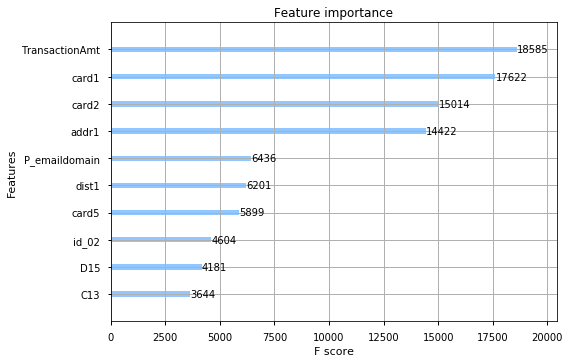

In [39]:
plot_importance(bst, max_num_features=10, importance_type='weight')
pyplot.show()

In [24]:
dsubmission = xgb.DMatrix(test)

In [25]:
preds = bst.predict(dsubmission)

In [26]:
test['isFraud'] = preds

In [27]:
test[['isFraud']].to_csv(data_path + '/submission.csv')

In [ ]:
# Count unique values for each column
for col, values in train_transaction.iteritems():
    num_uniques = values.nunique()
    print ('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
    print (values.unique())
    print ('\n')

In [ ]:
# Count unique values for each column
for col, values in train_identity.iteritems():
    num_uniques = values.nunique()
    print ('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
    print (values.unique())
    print ('\n')

In [ ]:
list(train_transaction)